In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import os
# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda:0


In [2]:


# Define the path to the root folder of dataset_2
root_folder = '/content/drive/MyDrive/Dataset_2'

# Define a mapping for the subfolder names to corresponding class labels
class_mapping = {
    'healthy': 'healthy',
    'diseased': 'diseased'
}

# Create a list to store all class-label pairs
class_label_pairs = []

# Iterate over the folders in the root folder
for class_folder in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_folder)
    # Check if the item in the root folder is a directory
    if os.path.isdir(class_path):
        # Iterate over the subfolders (healthy and diseased) in each class folder
        for subfolder in os.listdir(class_path):
            subfolder_path = os.path.join(class_path, subfolder)
            # Check if the item in the class folder is a directory
            if os.path.isdir(subfolder_path):
                # Create the class label based on the class folder name and subfolder name
                class_label = f'{class_folder}_{class_mapping[subfolder]}'
                # Append the class label and its corresponding folder path to the list
                class_label_pairs.append((class_label, subfolder_path))
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
# Load the dataset using ImageFolder and modify class labels
dataset = torchvision.datasets.ImageFolder(root=root_folder, transform=transform)

# Modify class labels based on the class-label pairs
dataset.classes = [label for _, label in class_label_pairs]
dataset.class_to_idx = {label: idx for idx, (class_name, label) in enumerate(class_label_pairs)}

In [3]:
from torch.utils.data import random_split
# Define the size of the training, validation, and test sets
train_size = int(0.7 * len(dataset))
validation_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - validation_size

# Split the dataset into training, validation, and test sets
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Print the sizes of the training, validation, and test sets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(validation_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 2155
Validation dataset size: 307
Test dataset size: 617


In [4]:
import torchvision.models as models

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)
# Initialize ResNet18 model

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
# Modify the final fully connected layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)  # 16 classes
model = model.to(device)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Initialize Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

print("the number of classes is ", len(train_dataset.dataset.classes))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.0MB/s]


the number of classes is  16


Epoch [1/15], Train Accuracy: 42.41%, Train Loss: 1.7589, Valid Accuracy: 74.07%, Valid Loss: 1.2344
Epoch [2/15], Train Accuracy: 81.30%, Train Loss: 1.0372, Valid Accuracy: 90.76%, Valid Loss: 0.7654
Epoch [3/15], Train Accuracy: 89.00%, Train Loss: 0.7169, Valid Accuracy: 92.71%, Valid Loss: 0.5569
Epoch [4/15], Train Accuracy: 90.35%, Train Loss: 0.5584, Valid Accuracy: 93.19%, Valid Loss: 0.4290
Epoch [5/15], Train Accuracy: 92.16%, Train Loss: 0.4558, Valid Accuracy: 94.49%, Valid Loss: 0.3675
Epoch [6/15], Train Accuracy: 92.62%, Train Loss: 0.3959, Valid Accuracy: 95.62%, Valid Loss: 0.3023
Epoch [7/15], Train Accuracy: 93.78%, Train Loss: 0.3465, Valid Accuracy: 95.14%, Valid Loss: 0.2708
Epoch [8/15], Train Accuracy: 94.06%, Train Loss: 0.3157, Valid Accuracy: 95.62%, Valid Loss: 0.2503
Epoch [9/15], Train Accuracy: 94.90%, Train Loss: 0.2904, Valid Accuracy: 96.76%, Valid Loss: 0.2173
Epoch [10/15], Train Accuracy: 94.85%, Train Loss: 0.2635, Valid Accuracy: 97.24%, Valid Lo

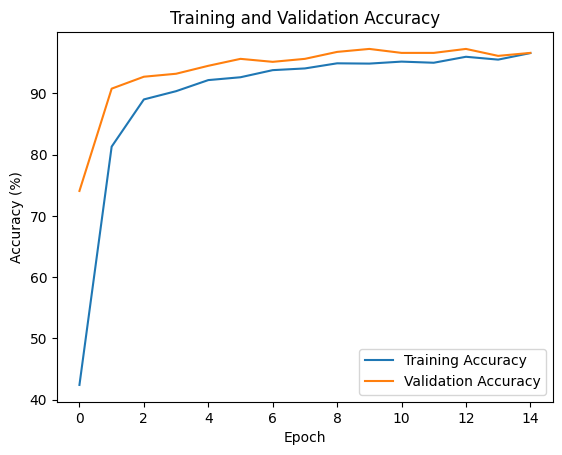

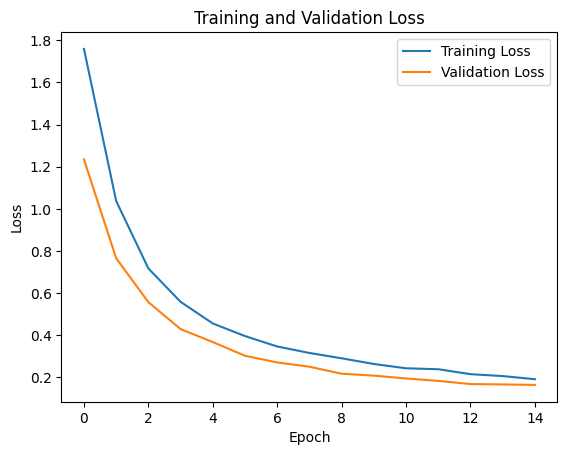

In [5]:
# Lists to store metrics
train_accuracy_history = []
valid_accuracy_history = []
train_loss_history = []
valid_loss_history = []

# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels_train = []
    predicted_labels_train = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels_train.extend(labels.cpu().numpy())
        predicted_labels_train.extend(predicted.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)

    epoch_train_accuracy = 100 * correct / total
    epoch_train_loss = running_loss / len(train_dataset)
    train_accuracy_history.append(epoch_train_accuracy)
    train_loss_history.append(epoch_train_loss)

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels_valid = []
    predicted_labels_valid = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels_valid.extend(labels.cpu().numpy())
        predicted_labels_valid.extend(predicted.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)

    epoch_valid_accuracy = 100 * correct / total
    epoch_valid_loss = running_loss / len(test_dataset)
    valid_accuracy_history.append(epoch_valid_accuracy)
    valid_loss_history.append(epoch_valid_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {epoch_train_accuracy:.2f}%, Train Loss: {epoch_train_loss:.4f}, Valid Accuracy: {epoch_valid_accuracy:.2f}%, Valid Loss: {epoch_valid_loss:.4f}')

# Generate classification report for training data
train_classification_report = classification_report(true_labels_train, predicted_labels_train)

# Generate classification report for validation data
valid_classification_report = classification_report(true_labels_valid, predicted_labels_valid)

# Print classification reports
print("Training Classification Report:")
print(train_classification_report)
print("Validation Classification Report:")
print(valid_classification_report)

# Plot training and validation accuracy
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(valid_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [6]:
torch.save(model.state_dict(), '/content/drive/My Drive/resnet18Dataset2_TransferLmodel.pth')

In [9]:
from sklearn.metrics import accuracy_score, classification_report
# Load the saved model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
# Modify the final fully connected layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)  # 16 classes
model.load_state_dict(torch.load('/content/drive/My Drive/resnet18Dataset2_TransferLmodel.pth'))
model.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.9724473257698542
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        73
           1       0.98      0.97      0.97        91
           2       0.98      1.00      0.99        48
           3       0.94      0.96      0.95       100
           4       0.96      0.97      0.97       109
           5       1.00      0.97      0.98        61
           6       1.00      1.00      1.00        48
           7       1.00      0.98      0.99        87

    accuracy                           0.97       617
   macro avg       0.98      0.98      0.98       617
weighted avg       0.97      0.97      0.97       617

